In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
# Load and inspect the data
video_features = pd.read_csv('online_videos/video_features.csv')
video_count = pd.read_csv('online_videos/video_count.csv')

In [3]:
video_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 5 columns):
video_id             2785 non-null int64
video_length         2785 non-null int64
video_language       2785 non-null object
video_upload_date    2785 non-null object
video_quality        2785 non-null object
dtypes: int64(2), object(3)
memory usage: 108.9+ KB


In [4]:
video_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41775 entries, 0 to 41774
Data columns (total 3 columns):
video_id    41775 non-null int64
count       41775 non-null int64
date        41775 non-null object
dtypes: int64(2), object(1)
memory usage: 979.2+ KB


In [5]:
video_features.head()

,video_id,video_length,video_language,video_upload_date,video_quality
0,2374,1760,Cn,2014-12-06,480p
1,1897,489,Cn,2014-12-10,720p
2,2386,1273,Es,2014-12-05,480p
3,2912,986,Es,2014-12-10,240p
4,2432,1050,Other,2014-12-10,480p


In [6]:
video_count.head()

,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08


In [7]:
# Convert the date field in the video_count table into a datetime field
video_count.date = pd.to_datetime(video_count.date)

In [8]:
video_count.date.min()

Timestamp('2015-01-01 00:00:00')

In [9]:
video_count.date.max()

Timestamp('2015-01-15 00:00:00')

I'm using the Kmeans algorithm to cluster the videos based on their timeseries data. Observing the clusters formed by the algorithm will help us identify which of the three categories each video belong to.

In [10]:
# Here I'm creating two timeseries matrices. The first matrix will be used to visualize the results of the clustering.
# Each row in the matrix pertains to a specific video. The columns represent the daily view counts for the video. 
timeseries_matrix = np.zeros((video_features.shape[0],15))

# This is the feature matrix I intend to use for clustering. Same idea as the matrix above, but I'm differencing the timeseries
# data in order to get the change in video counts per day.
timeseries_diff = np.zeros((video_features.shape[0],14))

In [11]:
# Populate the timeseries matricies
pos = 0
video_ids = []
for vid, group in video_count.groupby('video_id'):
    video_ids.append(vid)
    view_counts = group.sort_values('date')['count']
    timeseries_matrix[pos] = view_counts.values
    timeseries_diff[pos] = view_counts.diff(1)[1:].values
    pos += 1

In [12]:
# Now cluster the data
kmeans = KMeans(n_clusters=4,max_iter=1000).fit(timeseries_diff)

In [13]:
# Split the data into groups and visualize the results.
group1 = timeseries_matrix[kmeans.labels_ == 0]
group2 = timeseries_matrix[kmeans.labels_ == 1]
group3 = timeseries_matrix[kmeans.labels_ == 2]
group4 = timeseries_matrix[kmeans.labels_ == 3]

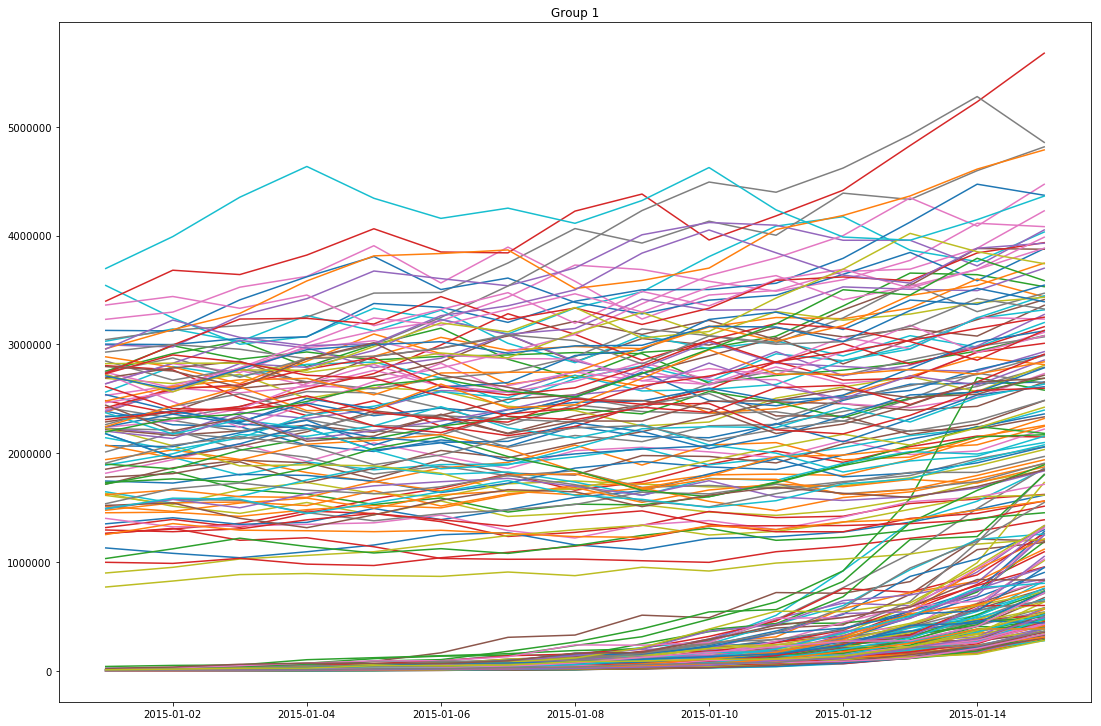

In [14]:
# Visualize the data for Group 1
plt.figure(figsize=(18.5, 12.5))
dates = pd.date_range(video_count.date.min(), video_count.date.max())
for row in xrange(group1.shape[0]):
    plt.plot(dates, group1[row])
plt.title("Group 1")

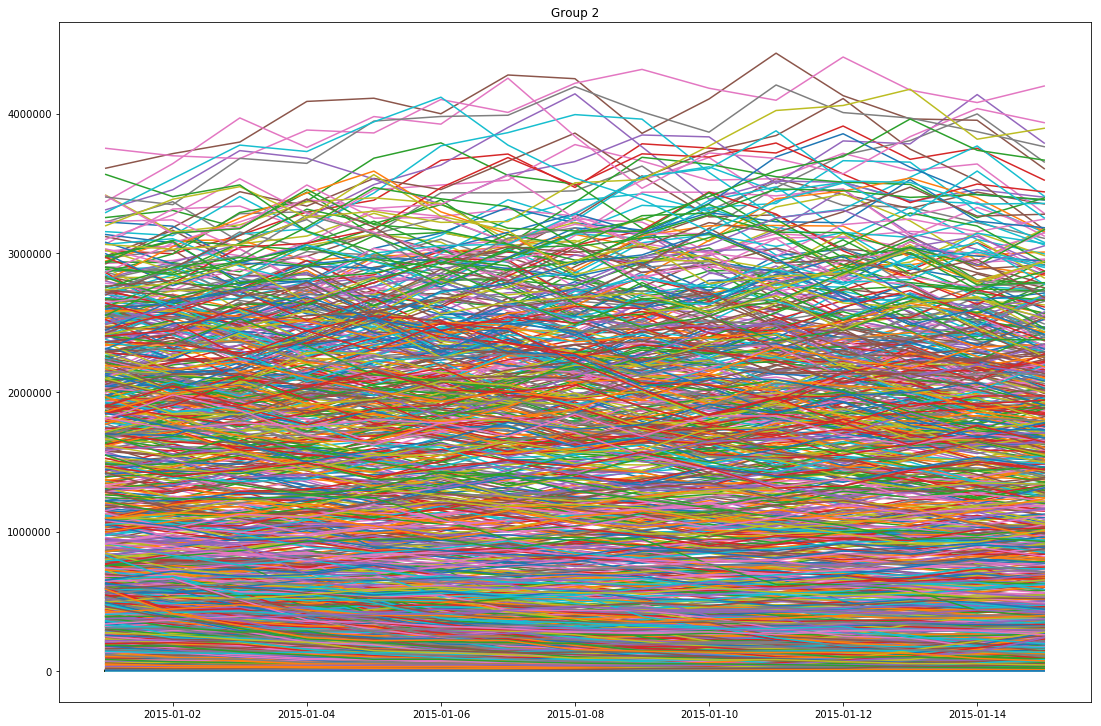

In [15]:
# Visualize the data for Group 2
plt.figure(figsize=(18.5, 12.5))
dates = pd.date_range(video_count.date.min(), video_count.date.max())
for row in xrange(group2.shape[0]):
    plt.plot(dates, group2[row])
plt.title("Group 2")

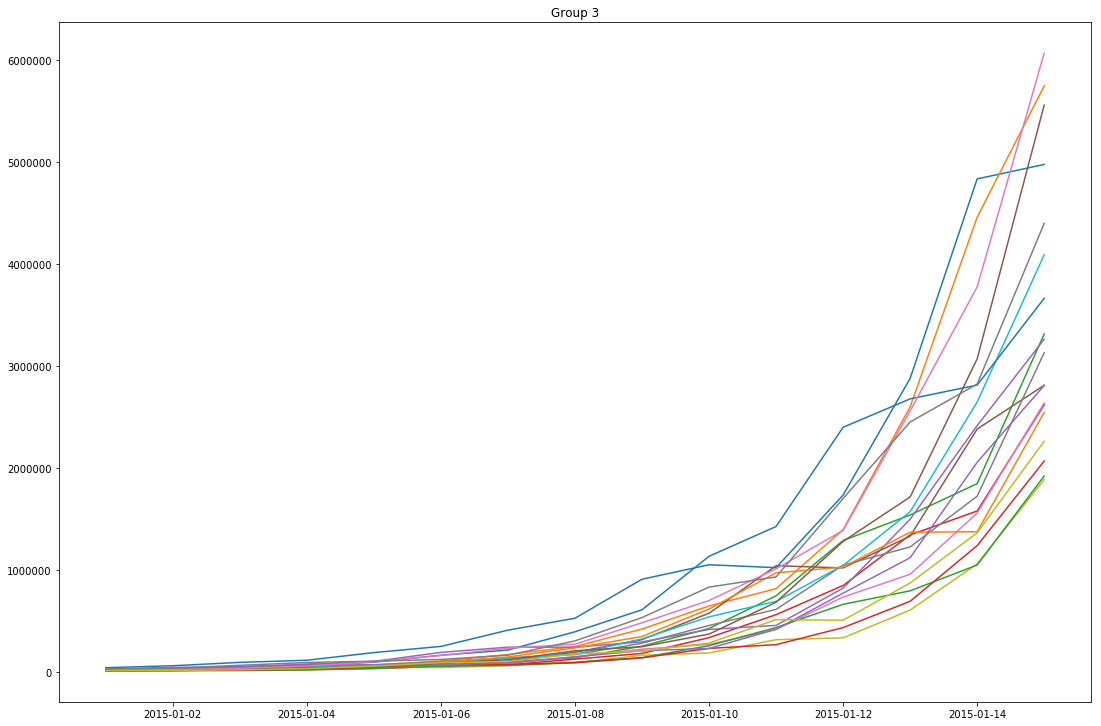

In [16]:
# Visualize the data for Group 3
plt.figure(figsize=(18.5, 12.5))
dates = pd.date_range(video_count.date.min(), video_count.date.max())
for row in xrange(group3.shape[0]):
    plt.plot(dates, group3[row])
plt.title("Group 3")

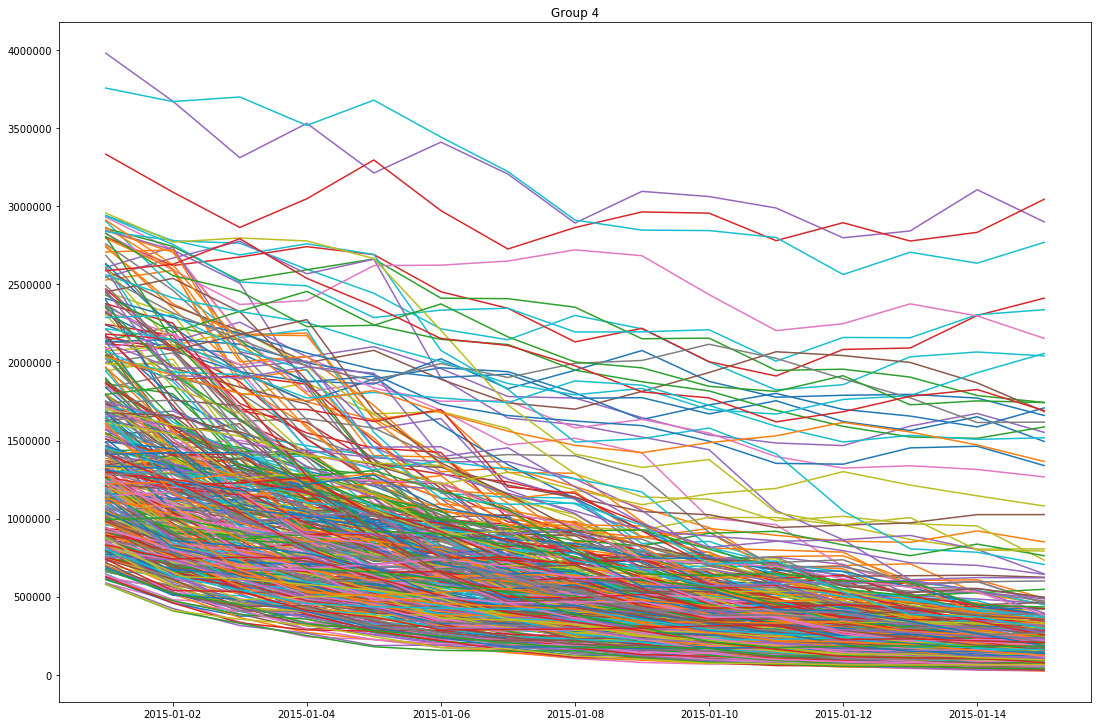

In [17]:
# Visualize the data for Group 4
plt.figure(figsize=(18.5, 12.5))
dates = pd.date_range(video_count.date.min(), video_count.date.max())
for row in xrange(group4.shape[0]):
    plt.plot(dates, group4[row])
plt.title("Group 4")

** We'll classify Videos in Group 1 as "Stable and Popular", videos in Group 2 and Group 4 as "Everything Else", and videos in Group 3 as "Hot".**

Q. What are the characteristics of "hot" videos?

In [34]:
video_ids = np.array(video_ids)
hot_videos = video_ids[kmeans.labels_ == 2]
stable_and_popular_videos = video_ids[kmeans.labels_ == 0]
other_videos = video_ids[(kmeans.labels_ == 1) | (kmeans.labels_ == 3)]

In [35]:
def classify_vid(vid):
    if vid in hot_videos:
        return 'HOT'
    elif vid in stable_and_popular_videos:
        return 'STABLE AND POPULAR'
    else:
        return 'OTHER'

In [36]:
video_features['video_type'] = video_features.video_id.apply(classify_vid)

In [37]:
def plot_bars(ax, df, atitle, field,value_list):
    value_counts = df[field].value_counts()
    cnts = []
    for val in value_list:
        if val in value_counts:
            cnts.append(value_counts[val])
        else:
            cnts.append(0)
    ind = range(len(value_list))
    ax.bar(ind,cnts)
    ax.set_title(atitle)
    ax.set_xticks(ind)
    ax.set_xticklabels(value_list)

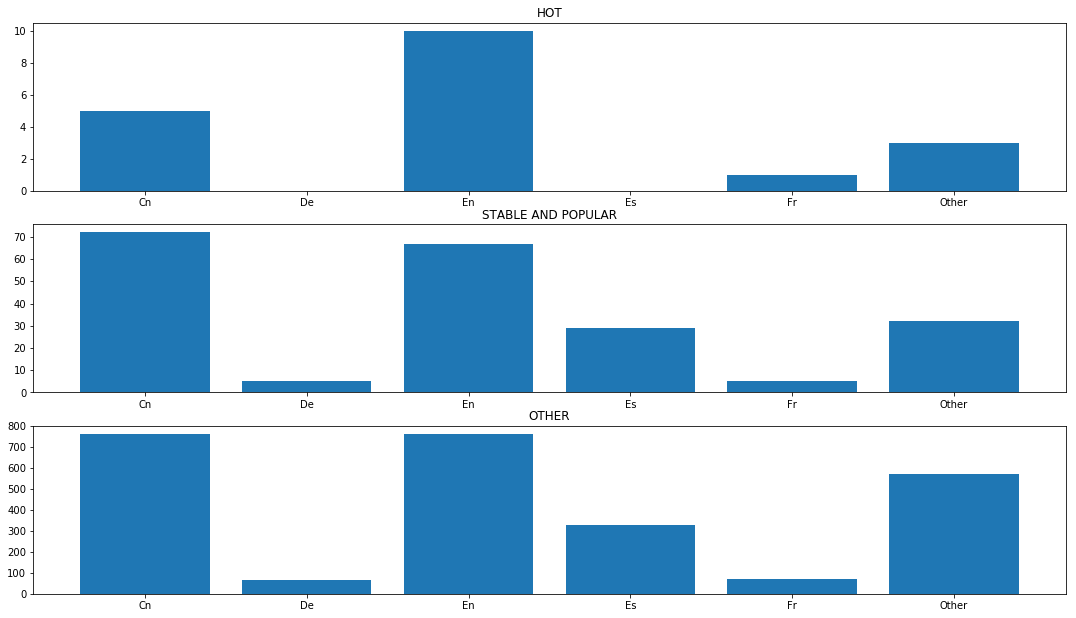

In [38]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(18.5, 10.5)
vid_types = ['HOT','STABLE AND POPULAR','OTHER']
pos = 0
for i in range(3):
    values = sorted(video_features.video_language.unique())
    df = video_features[video_features.video_type == vid_types[i]]
    plot_bars(axes[i],df,vid_types[i],'video_language',values)
plt.legend()

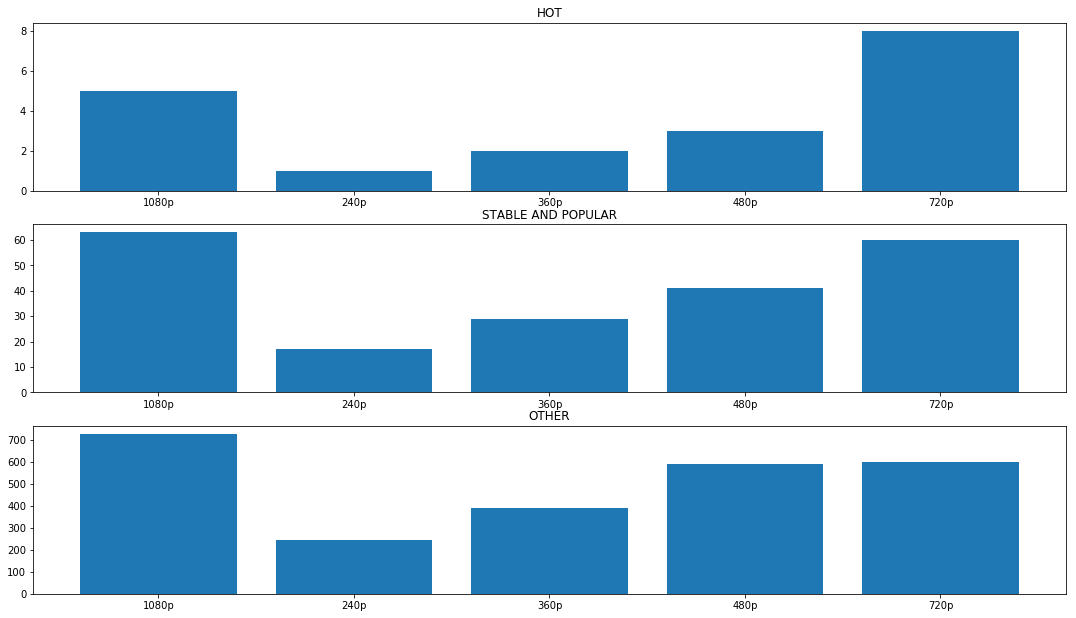

In [39]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(18.5, 10.5)
vid_types = ['HOT','STABLE AND POPULAR','OTHER']
pos = 0
for i in range(3):
    values = sorted(video_features.video_quality.unique())
    df = video_features[video_features.video_type == vid_types[i]]
    plot_bars(axes[i],df,vid_types[i],'video_quality',values)
plt.legend()

{'boxes': [<matplotlib.lines.Line2D at 0x1722e860>,
 'caps': [<matplotlib.lines.Line2D at 0x1723b588>,
 'fliers': [<matplotlib.lines.Line2D at 0x17249630>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x172490b8>,
 'whiskers': [<matplotlib.lines.Line2D at 0xe767d30>,
  <matplotlib.lines.Line2D at 0x172b3d30>]}

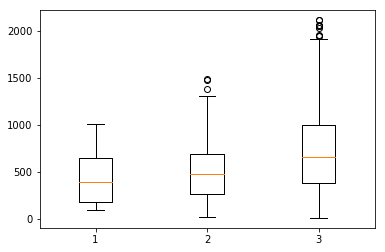

In [40]:
data = []
data.append(video_features[video_features.video_type == 'HOT'].video_length)
data.append(video_features[video_features.video_type == 'STABLE AND POPULAR'].video_length)
data.append(video_features[video_features.video_type == 'OTHER'].video_length)
plt.boxplot(data)

**"Hot" videos tend to be short in length and high in quality**

Q. After having identified the characteristics of the hot videos, how would you use this
information from a product standpoint?  

** I would encourage video uploaders on the platform to record their videos in high resolution (720p or 1280p) and keep videos under 10 minutes in length to increase their viewership.**